In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
from IPython.display import clear_output
from collections import deque
from tqdm.notebook import tqdm
from collections import deque

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K

tf.compat.v1.disable_eager_execution()

In [2]:
import gym

<h1> Double DQN

In [3]:
class Double_DQAgent():
    def __init__(self, 
                 observation_space, 
                 action_space,
                 gamma=0.99, 
                 lr=0.001,
                 maxlen = 20000):
        self.observation_space = observation_space
        self.action_space = action_space
        self.gamma = gamma
        self.lr = lr
        self.buffer = deque(maxlen = maxlen)
        self.model = self.build_model(name='model')
        self.target_model = self.build_model(name='target')
        
    def update(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, s, a, r, s_, t):
        self.buffer.append([s, a, r, s_, t])

    def get_batch(self, batch_size):
        if len(self.buffer) < batch_size:
            return None
        
        batch = random.sample(self.buffer, k=batch_size)
        
        S = np.array([val[0] for val in batch])
        A = np.array([val[1] for val in batch])
        R = np.array([val[2] for val in batch])
        S_ = np.array([val[3] for val in batch])
        T = np.array([val[4] for val in batch])

        return S, A, R, S_, T
    
    def build_model(self, name):
        model = keras.Sequential(name = name)
        model.add(keras.Input(shape=self.observation_space))
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dense(self.action_space, activation='linear'))
        
        model.compile(
            optimizer=keras.optimizers.legacy.Adam(learning_rate=self.lr),
            loss='mse'
        )
        return model
    
    def predict(self, observation):
        return self.model.predict(np.array([observation]), verbose=False)[0]
    
    def predict_action(self, observation):
        return np.argmax(self.predict(observation))
    
    def e_greedy(self, observation, e=0.1):
        if random.random() >= e:
            return self.predict_action(observation)
        return random.randint(0, self.action_space-1)
    
    def train(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        S, A, R, S_, T = self.get_batch(batch_size)
        
        Q_values = self.model.predict(S, verbose=False)
        
        new_Q = self.target_model.predict(S_, verbose=False)

        # Select the best action using the main model
        best_actions = np.argmax(self.model.predict(S_, verbose=False), axis=1)
        
        # Get the Q-values for the selected best actions from the target model
        max_new_Q = new_Q[np.arange(batch_size), best_actions]
        
        Y = Q_values
        for i in range(batch_size):
            if not T[i]:  
                Y[i][A[i]] = R[i] + self.gamma * max_new_Q[i]  # Q-learning update
            else:  
                Y[i][A[i]] = R[i]
        
        self.model.fit(S, Y, verbose=False)


## Difference Between DQN and Double DQN

### DQN (Deep Q-Network)
In the traditional **DQN**, the update rule for the Q-value is as follows:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q'(s', a') - Q(s, a) \right)
$$
DQN tends to **overestimate** Q-values because it uses the same network to select and evaluate the next action.

### Double DQN
**Double DQN** addresses this by using two networks:
1. **Online network (Q)**: Used for selecting actions.
2. **Target network (Q')**: Used for evaluating the Q-value of the selected action.

In **Double DQN**, the update rule becomes:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma Q'(s', \text{argmax}_{a'} Q(s', a')) - Q(s, a) \right)
$$

Where:
- The **online network** selects the next action: $$ a' = \text{argmax}_{a'} Q(s', a') $$
- The **target network** evaluates the Q-value for the selected action: $$ Q'(s', a') $$

This reduces overestimation by separating action selection from action evaluation.


---
Note: The difference between DQN with online offline network with Double DQN is how them update the Q-learning function. While traditional DQN update current q value by the maximum q value of the next state, Double DQN update the current q value by the next state q value correponding to the action have been choosen


In [4]:
env = gym.make("LunarLander-v2")
agent = Double_DQAgent(env.observation_space.shape, env.action_space.n)

episodes = 2000
max_t = 500
e=0.05
scores = []
avgs = []
time = 0
frequency = 400

for episode in range(episodes):
    observation, _ = env.reset()
    
    score = 0
    for t in range(max_t):
        time += 1
        s = observation
        a = agent.e_greedy(s, e=e)
        observation, reward, terminated, _, _ = env.step(a)
        score +=  reward
        s_ = observation
        agent.remember(s, a, reward, s_, terminated)
        agent.train(batch_size=32)
        if time % frequency == 0:
            agent.update()
        if terminated:
            break
    scores.append(score)
    avgs.append(np.sum(scores[-50:])/len(scores[-50:]))
    print(f"episode: {episode}, e: {e}, t: {t}, score: {score : .2f}, avg score: {avgs[-1]: .2f}")
    if avgs[-1] >= 200:
        break

c:\Users\admin\anaconda3\envs\test\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
c:\Users\admin\anaconda3\envs\test\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 0, e: 0.05, t: 81, score: -415.90, avg score: -415.90
episode: 1, e: 0.05, t: 63, score: -144.03, avg score: -279.97
episode: 2, e: 0.05, t: 67, score: -296.20, avg score: -285.38
episode: 3, e: 0.05, t: 68, score: -258.27, avg score: -278.60
episode: 4, e: 0.05, t: 54, score: -86.43, avg score: -240.17
episode: 5, e: 0.05, t: 56, score: -362.91, avg score: -260.62
episode: 6, e: 0.05, t: 57, score: -106.23, avg score: -238.57
episode: 7, e: 0.05, t: 84, score: -130.14, avg score: -225.01
episode: 8, e: 0.05, t: 57, score: -83.51, avg score: -209.29
episode: 9, e: 0.05, t: 141, score: -202.97, avg score: -208.66
episode: 10, e: 0.05, t: 80, score: -155.51, avg score: -203.83
episode: 11, e: 0.05, t: 79, score: -411.64, avg score: -221.15
episode: 12, e: 0.05, t: 82, score: -238.04, avg score: -222.45
episode: 13, e: 0.05, t: 78, score: -141.90, avg score: -216.69
episode: 14, e: 0.05, t: 55, score: -129.80, avg score: -210.90
episode: 15, e: 0.05, t: 83, score: -185.98, avg sc

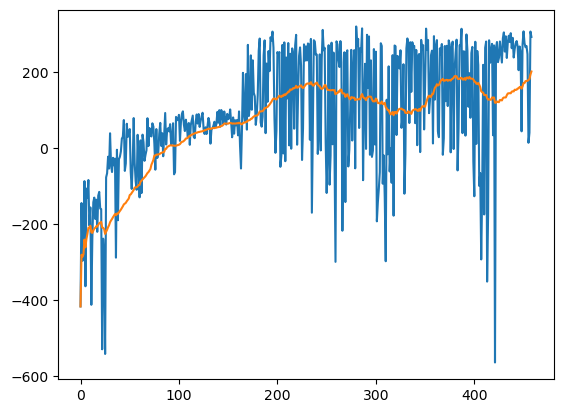

In [5]:
plt.plot(scores)
plt.plot(avgs)
plt.show()

## Mutiple run test

Running test 1/5...
episode: 0, e: 0.05, t: 85, score: -137.09, avg score: -137.09
episode: 1, e: 0.05, t: 51, score: -339.29, avg score: -238.19
episode: 2, e: 0.05, t: 117, score: -272.89, avg score: -249.76
episode: 3, e: 0.05, t: 95, score: -240.26, avg score: -247.38
episode: 4, e: 0.05, t: 81, score: -345.36, avg score: -266.98
episode: 5, e: 0.05, t: 104, score: -393.46, avg score: -288.06
episode: 6, e: 0.05, t: 135, score: -523.84, avg score: -321.74
episode: 7, e: 0.05, t: 125, score: -393.51, avg score: -330.71
episode: 8, e: 0.05, t: 201, score: -461.05, avg score: -345.20
episode: 9, e: 0.05, t: 319, score:  255.74, avg score: -285.10
episode: 10, e: 0.05, t: 499, score:  13.25, avg score: -257.98
episode: 11, e: 0.05, t: 499, score: -62.79, avg score: -241.71
episode: 12, e: 0.05, t: 499, score: -33.66, avg score: -225.71
episode: 13, e: 0.05, t: 499, score: -49.24, avg score: -213.10
episode: 14, e: 0.05, t: 137, score: -265.80, avg score: -216.62
episode: 15, e: 0.05, t

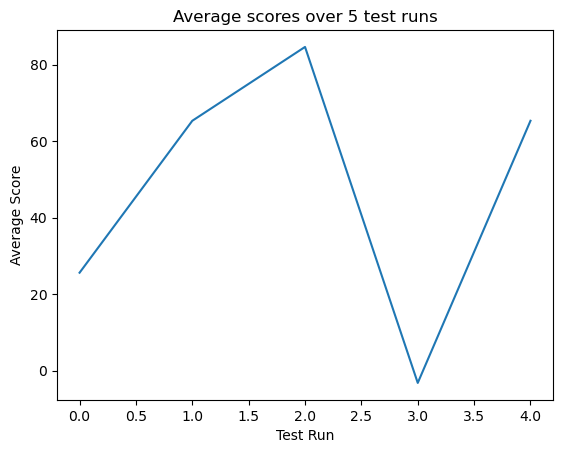

In [7]:
def run_single_test(env, agent, episodes=500, max_t=500, e=0.05, frequency = 400):
    scores = []
    avgs = []
    time = 0 
    for episode in range(episodes):
        observation, _ = env.reset()
        score = 0
        for t in range(max_t):
            time += 1
            s = observation
            a = agent.e_greedy(s, e=e)
            observation, reward, terminated, _, _ = env.step(a)
            score +=  reward
            s_ = observation
            agent.remember(s, a, reward, s_, terminated)
            agent.train(batch_size=32)
            if time % frequency == 0:
                agent.update()
            if terminated:
                break
        scores.append(score)
        avgs.append(np.sum(scores[-50:]) / len(scores[-50:]))
        print(f"episode: {episode}, e: {e}, t: {t}, score: {score: .2f}, avg score: {avgs[-1]: .2f}")


    return scores, avgs

def run_multiple_tests(env, agent_class, num_tests=5, episodes=300, max_t=500, e=0.05):
    all_test_scores = []
    for test in range(num_tests):
        print(f"Running test {test + 1}/{num_tests}...")
        agent = agent_class(env.observation_space.shape, env.action_space.n)
        scores, avgs = run_single_test(env, agent, episodes=episodes, max_t=max_t, e=e)
        all_test_scores.append(np.mean(scores))  # Store the average score for this test

    overall_avg_score = np.mean(all_test_scores)
    print(f"\nAverage score over {num_tests} test runs: {overall_avg_score:.2f}")

    return all_test_scores

env = gym.make("LunarLander-v2")

num_tests = 5

all_test_scores = run_multiple_tests(env, Double_DQAgent, num_tests=num_tests, episodes=300, max_t=500, e=0.05)

plt.plot(all_test_scores)
plt.title(f'Average scores over {num_tests} test runs')
plt.xlabel('Test Run')
plt.ylabel('Average Score')
plt.show()